# Inference of parameters with latent variables (SEIR model)
In this notebook, we consider the SEIR model with symptomatically and asymptomatically infected. We are trying to infer the parameters of the model 

* $\alpha$ (fraction of asymptomatic infectives), 
* $\beta$ (probability of infection on contact), 
* $\gamma_{E}$ (rate from exposed to infected)
* $\gamma_{I_a}$ (rate of recovery for asymptomatic infected individuals), and
* $\gamma_{I_s}$ (rate of recovery for symptomatic infected individuals) 


when partially observed data ($I_s$ only) from a generated trajectory.

In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import pyross
import time 

## 1) Generate a trajectory
We generate a test trajectory on a population with two ages groups.

In [2]:
M  = 2              # the population has two age groups
N  = 1e6            # and this is the total population

# correct params
beta  = 0.02        # infection rate
gIa   = 1./7        # recovery rate of asymptomatic infectives
gIs   = 1./7        # recovery rate of asymptomatic infectives
gE    = 0.1         # exposed to infected rate
alpha = np.array([0.5, 0.2])       # fraction of asymptomatic infectives
fsa   = 0.8         # the self-isolation parameter (assumed to be known)

# set the age structure
fi = np.array([0.25, 0.75])  # fraction of population in age age group
Ni = N*fi

# set the contact structure
C = np.array([[18., 9.], [3., 12.]])

# set up initial condition
E0  = np.array([0, 0])  # each age group has exposed individuals,
Ia0 = np.array([1, 0])  # and asymptomatic infectives,
Is0 = np.array([5, 0])  # and also symptomatic infectives
R0  = np.array([0, 0])    # there are no recovered individuals initially
S0  = Ni - (E0 + Ia0 + Is0 + R0)

Tf = 200
Nf = Tf+1

def contactMatrix(t):
    return C

parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs, 'gE':gE, 'fsa':fsa}
true_parameters = parameters

# use pyross stochastic to generate traj and save 
sto_model = pyross.stochastic.SEIR(parameters, M, Ni)
data = sto_model.simulate(S0, E0, Ia0, Is0, contactMatrix, Tf, Nf, method='tau-leaping')
data_array = data['X']
np.save('latent_SEIR_traj.npy', data_array)

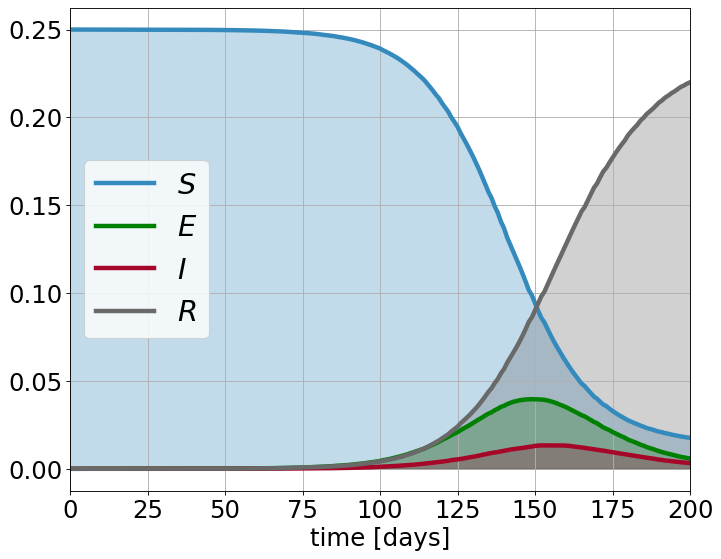

In [3]:
# plot the data and obtain the epidemic curve for one age group 
S  = data_array[:,0]
E  = data_array[:,2]
Ia = data_array[:,4]
Is = data_array[:,6]
t  = data['t']

fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})

plt.fill_between(t, 0, S/N, color="#348ABD", alpha=0.3)
plt.plot(t, S/N, '-', color="#348ABD", label='$S$', lw=4)

plt.plot(t, E/N, '-', color="green", label='$E$', lw=4)
plt.fill_between(t, 0, E/N, color='green', alpha=0.3)

plt.fill_between(t, 0, Is/N, color='#A60628', alpha=0.3)
plt.plot(t, Is/N, '-', color='#A60628', label='$I$', lw=4)

R=Ni[0]-S-Ia-Is-E; 
plt.fill_between(t, 0, R/N, color="dimgrey", alpha=0.3)
plt.plot(t, R/N, '-', color="dimgrey", label='$R$', lw=4)

plt.legend(fontsize=26); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)
plt.xlabel("time [days]")
plt.show()

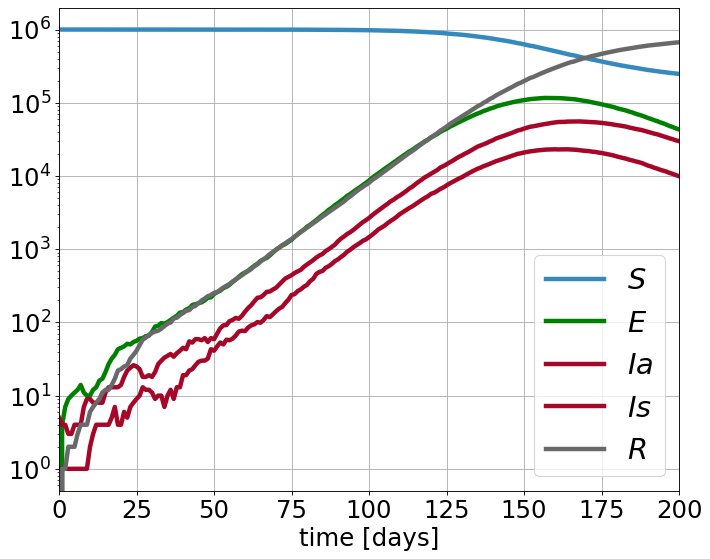

In [12]:
# plot the data and obtain the epidemic curve for one age group 
S  = np.sum(data_array[:,0:M], axis=1)
E  = np.sum(data_array[:,M:2*M], axis=1)
Ia = np.sum(data_array[:,2*M:3*M], axis=1)
Is = np.sum(data_array[:,3*M:4*M], axis=1)
R=N-S-Ia-Is-E
t  = data['t']

fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})
plt.semilogy(t, S, '-', color="#348ABD", label='$S$', lw=4)
plt.semilogy(t, E, '-', color="green", label='$E$', lw=4)
plt.semilogy(t, Ia, '-', color='#A60628', label='$Ia$', lw=4)
plt.semilogy(t, Is, '-', color='#A60628', label='$Is$', lw=4)
plt.semilogy(t, R, '-', color="dimgrey", label='$R$', lw=4)

plt.legend(fontsize=26); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)
plt.xlabel("time [days]")
plt.show()

## 2) Inference

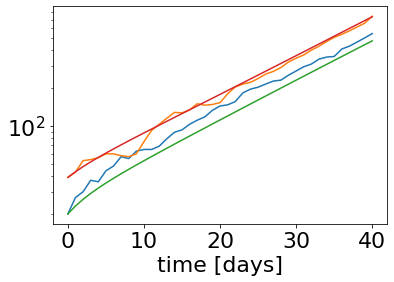

In [13]:
# load the data and rescale to intensive variables 
N_start = 50
Tf_inference = 40 # can truncate later 
Nf_inference = Tf_inference + 1

x = np.load('latent_SEIR_traj.npy').astype('float')
x = x[N_start:N_start+Nf_inference]
steps = 4 # number internal integration steps taken, must be an odd number 


# initialise the estimator 
estimator = pyross.inference.SEIR(parameters, M, Ni)


# make a fltr to get N-R and Is for each age class 
fltr=np.kron([[1, 1, 1, 1], [0, 0, 0, 1]], np.identity(M))
obs=np.einsum('ij,kj->ki', fltr, x)
x0=x[0]

# Compare the deterministic trajectory and the stochastic trajectory with the same 
# initial conditions and parameters 
estimator.set_det_model(parameters)
estimator.set_contact_matrix(contactMatrix)


time_points = np.linspace(0, Tf_inference, Nf_inference)
xm = estimator.integrate(x0, 0, Tf_inference, Nf_inference)

plt.semilogy(obs[:, -2:])
plt.semilogy(np.einsum('ij,kj->ki', fltr, xm)[:, -2:])
plt.xlabel("time [days]")
plt.show()


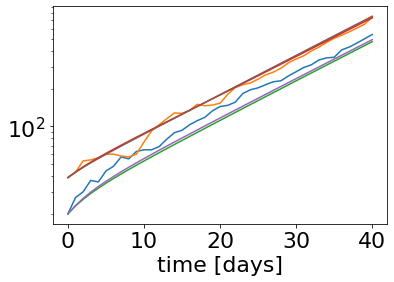

In [14]:
# test the approximation of the initial conditions by v 
zero_state = np.zeros((4*M))
zero_state[:M] = Ni 
dev = x0 - zero_state

coeff = np.linalg.norm(dev, ord=1)

init_priors = {
    'lin_mode_coeff':{
        'fltr':np.repeat([False, True, True, False], M),
        'mean':coeff, 
        'std':coeff, 
        'bounds':[0.1*coeff, 10*coeff]
    }
}
estimator.set_contact_matrix(contactMatrix)
x0_approx = estimator.get_mean_inits(init_priors, obs[0], fltr)
xm_approx = estimator.integrate(x0_approx, 0, Tf_inference, Nf_inference)

plt.semilogy(obs[:, -2:])
plt.semilogy(np.einsum('ij,kj->ki', fltr, xm)[:, -2:])
plt.semilogy(np.einsum('ij,kj->ki', fltr, xm_approx)[:, -2:])
plt.xlabel("time [days]")
plt.show()

In [15]:
# compute -log_p for the original (correct) parameters 
start_time = time.time() 
parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa,'gIs':gIs, 'gE':gE, 'fsa':fsa}

estimator.set_lyapunov_method('euler')
logp = estimator.minus_logp_red(parameters, x0, obs, fltr, Tf_inference, contactMatrix, tangent=True)
end_time = time.time()
print(logp) 
print(end_time - start_time)

515.8805794509707
0.046386003494262695


In [16]:
# make parameter guesses and set up bounds for each parameter 
eps = 1e-3

param_priors = {
    'alpha':{
        'mean': [0.5, 0.2], 
        'infer_scale': True,
        'scale_factor_std': 1, 
        'scale_factor_bounds': [eps, 10]
    }, 
    'beta':{
        'mean': 0.03, 
        'std': 0.02, 
        'bounds': [eps, 1]
    }, 
    'gE':{
        'mean': 0.11, 
        'std': 0.05, 
        'bounds': [eps, 0.2]
    }
}


# optimisation parameters 
ftol = 1e-5 # the relative tol in (-logp)  

# set up bounds, guess and stds for the rest of the params 
start_time = time.time()
estimator.set_lyapunov_method('euler')
res = estimator.latent_infer_parameters(obs, fltr, Tf_inference, contactMatrix, param_priors, init_priors, 
                                            tangent=False,
                                            cma_population=16,
                                            global_max_iter=200, global_atol=10, 
                                            verbose=True, ftol=ftol) 
end_time = time.time()
print(end_time - start_time)

Starting global minimisation...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 4 (seed=2370154442, Mon Jun 29 17:45:42 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 6.088287709719854e+02 1.0e+00 9.12e-01  2e-02  9e+02 0:00.9
    2     32 5.346950603934504e+02 1.7e+00 9.07e-01  1e-02  9e+02 0:01.6
    3     48 6.051137385234242e+02 2.1e+00 8.16e-01  1e-02  8e+02 0:02.4
    8    128 5.401886405493526e+02 3.5e+00 4.79e-01  6e-03  7e+02 0:05.9
   14    224 5.313070927396290e+02 7.1e+00 2.54e-01  3e-03  4e+02 0:10.2
   21    336 5.240448128316141e+02 1.2e+01 2.73e-01  3e-03  5e+02 0:15.5
   30    480 5.177304676212791e+02 1.3e+01 2.06e-01  1e-03  2e+02 0:21.8
   33    528 5.163298557642250e+02 7.2e+00 1.48e-01  6e-04  7e+01 0:24.0
Optimal value (global minimisation):  516.1414661672724
Starting local minimisation...
Optimal value (local minimisation):  516.1371238233327
25.661637783050537


In [17]:
# print the correct params and best estimates 
print('True parameters')
parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs, 'gE':gE,'fsa':fsa}
print(parameters)

best_estimates = res['map_params_dict']
print('\nBest estimates')
print(best_estimates)

print('\nTrue initial conditions: ') 
print((x0).astype('int'))

map_x0 = res['map_x0']
print('\nInferred initial conditions: ') 
print(map_x0.astype('int'))

True parameters
{'alpha': array([0.5, 0.2]), 'beta': 0.02, 'gIa': 0.14285714285714285, 'gIs': 0.14285714285714285, 'gE': 0.1, 'fsa': 0.8}

Best estimates
{'alpha': array([0.46852189, 0.18740876]), 'beta': 0.01792577726006612, 'gIa': array([0.14285714, 0.14285714]), 'gIs': array([0.14285714, 0.14285714]), 'gE': 0.13195889312948422, 'fsa': array([0.8, 0.8])}

True initial conditions: 
[249726 749677    121    123     24     17     20     39]

Inferred initial conditions: 
[249749 749716     94     89     27     10     20     39]


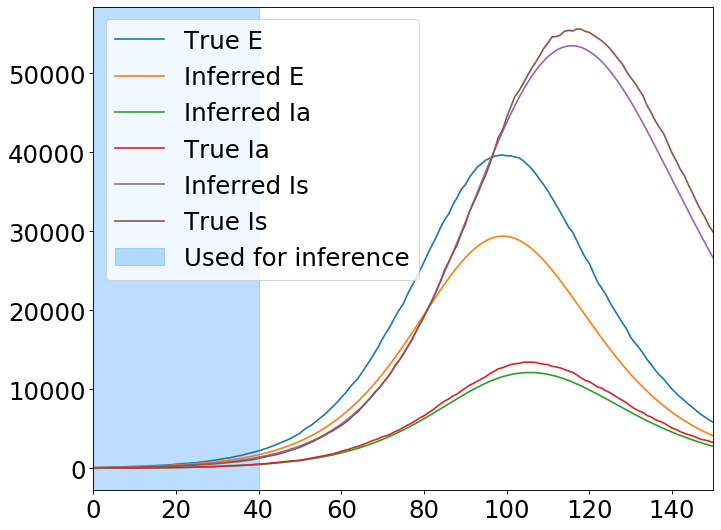

In [18]:
# plot the guessed trajectory and the true trajectory 
estimator.set_params(best_estimates)
estimator.set_det_model(best_estimates)
estimator.set_det_method('LSODA') # use more stable solver to integrate over the whole traj
x_det = estimator.integrate(x0, 0, Tf-N_start, Nf-N_start)
x = np.load('latent_SEIR_traj.npy').astype('float')[N_start:]
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})
plt.plot(x[:,M], label='True E')
plt.plot(x_det[:, M], label='Inferred E')
plt.plot(x_det[:, 2*M], label='Inferred Ia')
plt.plot(x[:,2*M], label='True Ia')
plt.plot(np.sum(x_det[:, 3*M:], axis=1), label='Inferred Is')
plt.plot(np.sum(x[:,3*M:], axis=1), label='True Is')
plt.axvspan(0, Tf_inference, 
           label='Used for inference',
           alpha=0.3, color='dodgerblue')
plt.xlim([0, Tf-N_start])
plt.legend()
plt.show()